<a href="https://www.kaggle.com/code/mehmetcubukcu/road-segmentation-unet-multiclass-comma?scriptVersionId=178919578" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
import cv2
import random
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
Road = np.array([64, 42, 42])
Lane = np.array([255,0,0])
Undrivable = np.array([128,128,96])
Movable = np.array([0,255,102])
Car = np.array([204,0,255])

def set_labels(mask_dataset):
    labels = []
    for i in range(mask_dataset.shape[0]):
        label = rgb_to_2D_label(mask_dataset[i])
        labels.append(label)
    labels = np.array(labels)
    labels = np.expand_dims(labels, axis=3)

    print("Unique labels in label dataset are: ", np.unique(labels))
    n_classes = len(np.unique(labels))
    from tensorflow.keras.utils import to_categorical
    labels_cat = to_categorical(labels, num_classes=n_classes)


    return labels_cat

def rgb_to_2D_label(label):

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Road, axis=-1)] = 0
    label_seg[np.all(label == Lane, axis=-1)] = 1
    label_seg[np.all(label == Undrivable, axis=-1)] = 2
    label_seg[np.all(label == Movable, axis=-1)] = 3
    label_seg[np.all(label == Car, axis=-1)] = 4

    label_seg = label_seg[:, :, 0]  # Just take the first channel, no need for all 3 channels

    return label_seg

In [4]:
# strategy = tf.distribute.MirroredStrategy()
np.random.seed(42)
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = "/kaggle/input/commaaicomplete/comma10k/imgs"
TRAIN_MASKS_PATH = '/kaggle/input/commaaicomplete/comma10k/masks'


# TRAIN_PATH = "/kaggle/input/commaai2000/comma_dataset_max/train_images"
# TRAIN_MASKS_PATH = '/kaggle/input/commaai2000/comma_dataset_max/train_masks'
# TEST_PATH = '/kaggle/input/commaai/comma_dataset/comma_dataset/test_images'
# TEST_MASKS_PATH = '/kaggle/input/commaai/comma_dataset/comma_dataset/test_masks'

train_image_files = os.listdir(TRAIN_PATH)
train_mask_files = os.listdir(TRAIN_MASKS_PATH)
# test_image_files = os.listdir(TEST_PATH)
# test_mask_files = os.listdir(TEST_MASKS_PATH)

numberOfClasses = 5

X_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, numberOfClasses), dtype=np.uint8)


images = []
masks = []
for n, image_file in tqdm(enumerate(train_image_files), total=len(train_image_files), desc="Train images..."):
    if os.path.splitext(image_file)[1].lower() == ".png":
      image_path = os.path.join(TRAIN_PATH, image_file)
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (IMG_HEIGHT,IMG_WIDTH))
      image = image / 255

      images.append(image)

for n, mask_file in tqdm(enumerate(train_mask_files), total=len(train_mask_files), desc="Train masks..."):
    if os.path.splitext(mask_file)[1].lower() == ".png":
      mask_path = os.path.join(TRAIN_MASKS_PATH, mask_file)
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      mask = cv2.resize(mask, (IMG_HEIGHT,IMG_WIDTH))

      masks.append(mask)


X_train, Y_train = np.array(images), np.array(masks)
del images
del masks


Y_train = set_labels(Y_train)

Train masks...: 100%|██████████| 9888/9888 [03:40<00:00, 44.75it/s]


Unique labels in label dataset are:  [0 1 2 3 4]


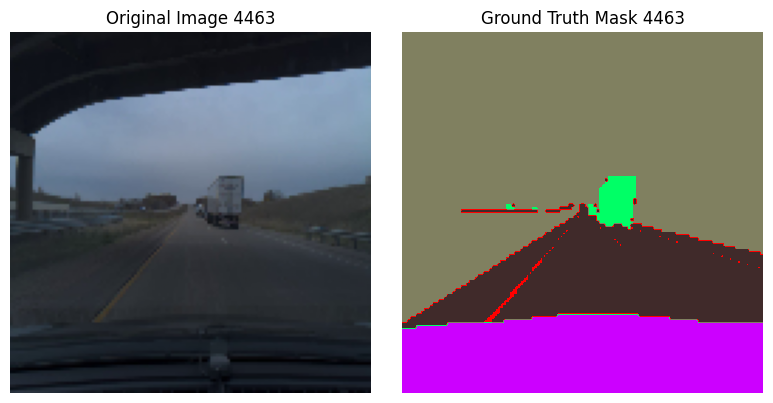

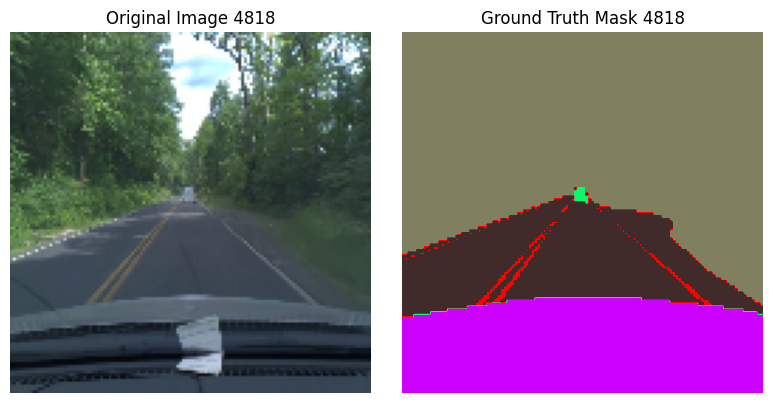

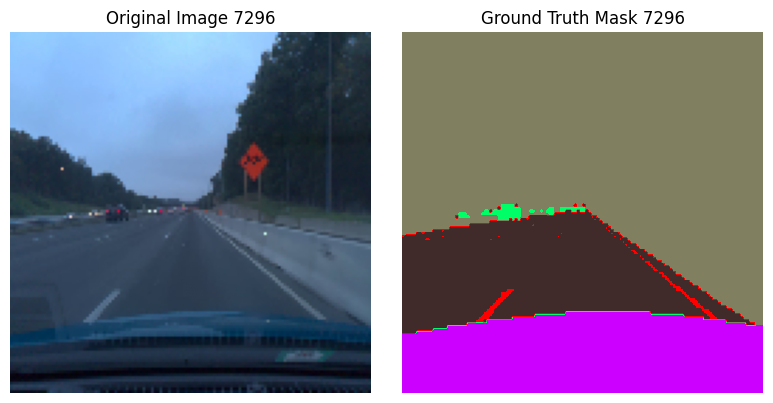

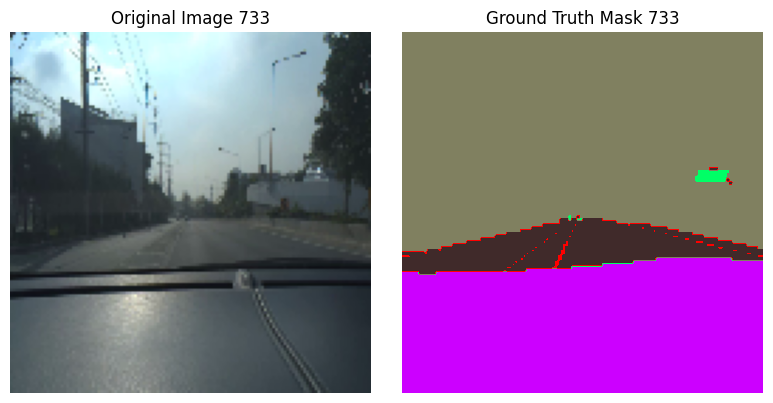

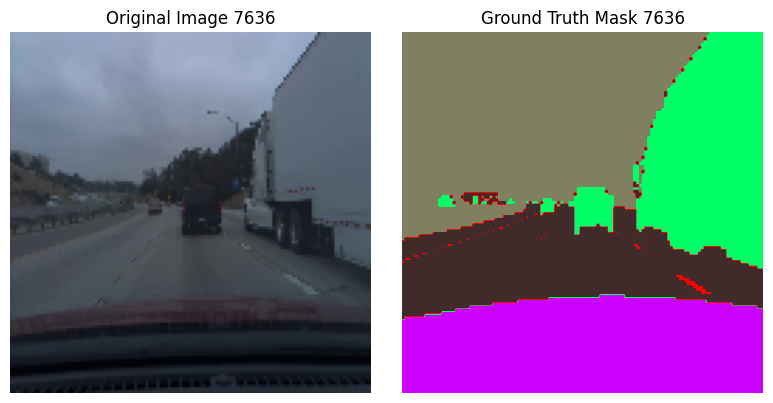

In [5]:
num_images_to_display = 5

selected_indices = np.random.choice(len(X_train), num_images_to_display, replace=False)

colors = [ Road / 255.0,Lane / 255.0,Undrivable / 255.0,  Movable / 255.0, Car / 255.0]
cmap = ListedColormap(colors)

    
for i, idx in enumerate(selected_indices):
    plt.figure(figsize=(8, 4))
    
    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx])
    plt.title(f"Original Image {idx}")
    plt.axis('off')
    
    # Display the corresponding mask with the custom colormap
    plt.subplot(1, 2, 2)
    
    # Convert one-hot encoded mask to integer labels
    mask_labels = np.argmax(Y_train[idx], axis=-1)
    
    # Display the mask using the custom colormap
    plt.imshow(mask_labels, cmap=cmap, vmin=0, vmax=4)  
    plt.title(f"Ground Truth Mask {idx}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
print(Y_train.shape)
print(X_train.shape)

(9888, 128, 128, 5)
(9888, 128, 128, 3)


In [7]:
def create_unet_model(numberOfClasses = 5, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    # Build the model
    inputs = tf.keras.layers.Input(input_shape)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(numberOfClasses, (1, 1), activation='softmax')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
#tf.compat.v1.disable_eager_execution()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

with strategy.scope():
    model = create_unet_model(numberOfClasses = 5)
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
#print(np.min(Y_train), np.max(Y_train))
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('model_for_lane.h5', verbose=1, save_best_only=True)]

results = model.fit(X_train, Y_train, batch_size=16, epochs=50,steps_per_epoch=62,validation_split=0.1, callbacks=callbacks)

Epoch 1/50


2024-05-21 10:41:50.157070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


62/62 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.5451
Epoch 1: val_loss improved from inf to 0.80687, saving model to model_for_lane.h5
62/62 [==============================] - 19s 87ms/step - loss: 1.1054 - accuracy: 0.5451 - val_loss: 0.8069 - val_accuracy: 0.7797
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/62 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.8472
Epoch 2: val_loss improved from 0.80687 to 0.59273, saving model to model_for_lane.h5
62/62 [==============================] - 4s 61ms/step - loss: 0.4780 - accuracy: 0.8477 - val_loss: 0.5927 - val_accuracy: 0.8095
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 0.3831 - accuracy: 0.8804
Epoch 3: val_loss improved from 0.59273 to 0.49121, saving model to model_for_lane.h5
62/62 [==============================] - 4s 61ms/step - loss: 0.3833 - accuracy: 0.8804 - val_loss: 0.4912 - val_accuracy: 0.8519
Epoch 4/50
61/62 [============================>.] - ETA: 0s - loss: 0.3540 - accuracy: 0.8890
Epoch 4: val_loss improved from 0.49121 to 0.45427, saving model to model_for_lane.h5
62/62 [==============================] - 4s 61ms/step - loss: 0.3539 - accuracy: 0.8890 - val_loss: 0.4543 - val_accuracy: 0.8693
Epoch 5/50
61/62 [============================>.] - ETA: 0s - loss: 0.3181 - accu

In [9]:
# X_test = np.zeros((len(test_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_test = np.zeros((len(test_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# test = []
# test_masks = []
# for n, image_file in enumerate(test_image_files):
#     if os.path.splitext(image_file)[1].lower() == ".png":
#       image_path = os.path.join(TEST_PATH, image_file)
#       image = cv2.imread(image_path)
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#       image = cv2.resize(image, (256,256))
#       image = image / 255

#       test.append(image)


# for n, mask_file in enumerate(test_mask_files):
#     if os.path.splitext(mask_file)[1].lower() == ".png":
#       mask_path = os.path.join(TEST_MASKS_PATH, mask_file)
#       mask = cv2.imread(mask_path)
#       mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#       mask = cv2.resize(mask, (256,256))

#       test_masks.append(mask)

# X_test, Y_test = np.array(test), np.array(test_masks)
# Y_test = set_labels(Y_test)

In [10]:
# # trained U-Net model
# model = load_model('/kaggle/working/model_for_lane.h5')


# y_pred = model.predict(X_test)

# num_samples = 5  # Adjust the number of samples to visualize

# colors = [ Road / 255.0,Lane / 255.0,Undrivable / 255.0,  Movable / 255.0, Car / 255.0]
# cmap = ListedColormap(colors)

# fig, axes = plt.subplots(num_samples, 3, figsize=(10, 3*num_samples))

# for i in range(num_samples):
    
#     # original image
#     axes[i, 0].imshow(X_test[i])
#     axes[i, 0].set_title("Original Image")
#     axes[i, 0].axis('off')

#     # ground truth mask
#     ground_mask = np.argmax(Y_test[i], axis=-1)
#     axes[i, 1].imshow(ground_mask, cmap=cmap, vmin=0, vmax=4)
#     axes[i, 1].set_title("Ground Truth Mask")
#     axes[i, 1].axis('off')

#     # predicted mask
#     predicted_mask = np.argmax(y_pred[i], axis=-1)
#     axes[i, 2].imshow(predicted_mask, cmap=cmap, vmin=0, vmax=4)
#     axes[i, 2].set_title("Predicted Mask")
#     axes[i, 2].axis('off')

# plt.tight_layout()
# plt.show()

In [11]:
# # trained model on training data
# y_pred = model.predict(X_train[0:10])

# num_samples = 10  # Adjust the number of samples to visualize

# colors = [ Road / 255.0,Lane / 255.0,Undrivable / 255.0,  Movable / 255.0, Car / 255.0]
# cmap = ListedColormap(colors)

# fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))  # Adjust the figsize here

# for i in range(num_samples):
#     # original image
#     axes[i, 0].imshow(X_train[i], interpolation='nearest')  # Set interpolation to 'nearest'
#     axes[i, 0].set_title("Original Image")
#     axes[i, 0].axis('off')

#     # ground truth mask
#     ground_mask = np.argmax(Y_train[i], axis=-1)
#     axes[i, 1].imshow(ground_mask, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')  # Set interpolation to 'nearest'
#     axes[i, 1].set_title("Ground Truth Mask")
#     axes[i, 1].axis('off')

#     # predicted mask
#     predicted_mask = np.argmax(y_pred[i], axis=-1)
#     axes[i, 2].imshow(predicted_mask, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')  # Set interpolation to 'nearest'
#     axes[i, 2].set_title("Predicted Mask")
#     axes[i, 2].axis('off')

# plt.tight_layout()
# plt.show()

In [12]:
# model.save("/kaggle/working/")

In [13]:
# import tensorflow as tf

# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/") # path to the SavedModel directory
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

In [14]:
# import tensorflow as tf
# converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quant_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_quant_model)

In [15]:
tf.saved_model.save(model,"/kaggle/working/" )


In [16]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)